# Reprojection and Error Algorithm Testing

Testing the error calculating error to be used for the loss function of future neural network. Also testing the process of reprojecting tomographyic reconstructions in order to be used in the error calculation as well as constructing datasets to test other neural network methods for alignment.

In [1]:
# Import packages
import numpy as np
import tomopy
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform

In [2]:
# Creating ground truth tomography
data = tomopy.shepp3d(256)
ang = tomopy.angles(181)
proj = tomopy.project(data, ang)

In [3]:
# Randomly determined misalignment axis
mis_axis = np.random.normal(0, 1, (200, 3))
mis_axis[:, :1] = mis_axis[:, :1]*4
mis_axis = np.round(mis_axis).astype(int)

In [4]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    prj_tmp = np.zeros_like(prj)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
            
        translation_matrix = np.float32([ [1,0,d_row], [0,1,d_col] ])
        prj_tmp[i, :, :] = cv2.warpAffine(prj_tmp[i, :, :], translation_matrix, (row, col))
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()
            
    return prj_tmp

In [5]:
# Creating misaligned projections
proj_mis = misalign(proj, mis_axis, ang_tilt = True)

In [6]:
def findError(proj, sx, sy, angle):
    proj_shifted = tomopy.shift_images(proj.copy(), sx, sy)
    print(proj_shifted.shape)
    recon_shifted = tomopy.recon(proj, angle, num_gridx = proj.shape[2], algorithm='gridrec', sinogram_order=False)
    print(recon_shifted.shape)
    reproj = tomopy.project(recon_shifted, angle, center = None, pad = False)
    print(reproj.shape)
    reproj_shifted = tomopy.shift_images(reproj, -sx, -sy)
    error = rmse(proj, reproj_shifted)
    return error

In [7]:
def rmse(proj1, proj2):
    error = np.sum((proj1 - proj2)**2)
    error /= float(proj1.shape[0] * proj1.shape[1] * proj1.shape[2])
    return np.sqrt(error)

## One Iteration Joint Realignment

In [8]:
# Use alignment algorithm with one iteration
proj_tmp, sx, sy, err = tomopy.align_joint(proj_mis.copy(), ang, iters = 1, algorithm = 'sirt')
proj_re = tomopy.shift_images(proj_tmp, sx, sy)

# Finding error for one iteration realignment
findError(proj_re, sx, sy, ang)

iter=0, err=0.2677649284946726
(181, 256, 366)
(256, 366, 366)
(181, 256, 366)


6.792596755216991

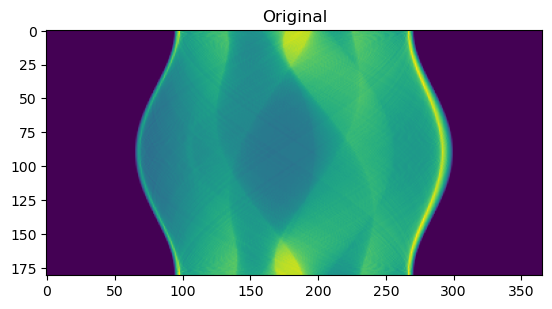

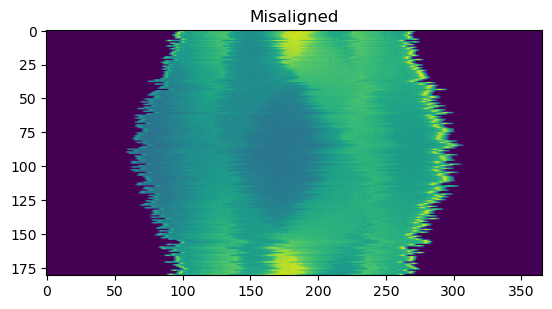

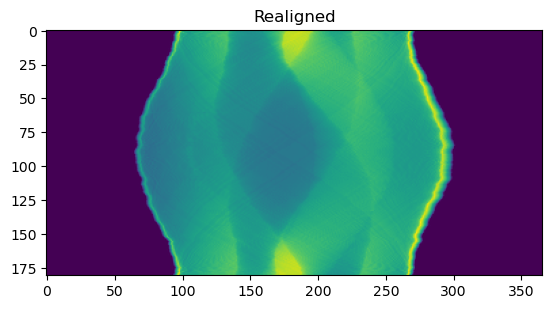

In [9]:
# Sinogram for original
plt.imshow(proj[:, 128, :])
plt.title('Original')
plt.show()

# Sinogram for misaligned
plt.imshow(proj_mis[:, 128, :])
plt.title('Misaligned')
plt.show()

# Sinogram for realgined
plt.imshow(proj_re[:, 128, :])
plt.title('Realigned')
plt.show()

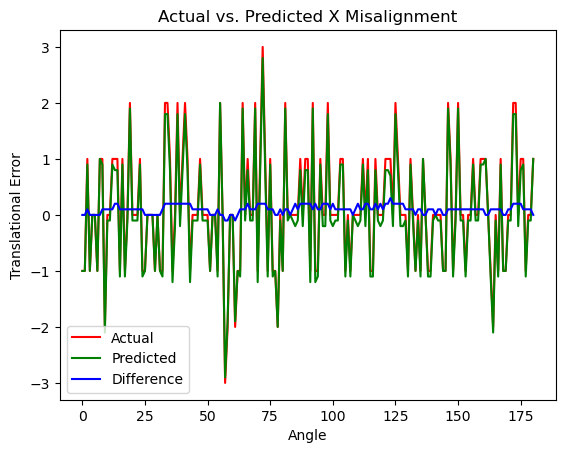

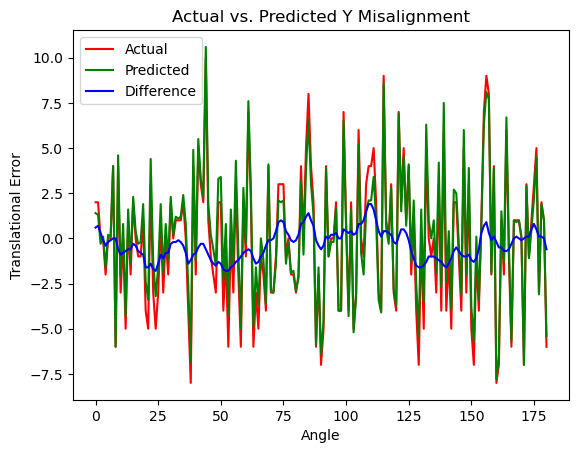

In [10]:
# Apply translations to original
true_x = mis_axis[:181, 1]
true_y = mis_axis[:181, 0]

# Plot shows the actual x misalignment vs. predicted
plt.plot(true_x, color = 'r', label = 'Actual')
plt.plot(sx, color = 'g', label = 'Predicted')
plt.plot(true_x - sx, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted X Misalignment")
plt.legend()
plt.show()

# Plot shows the actual x and y misalignment vs. modeled
plt.plot(true_y, color = 'r', label = 'Actual')
plt.plot(sy, color = 'g', label = 'Predicted')
plt.plot(true_y - sy, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted Y Misalignment")
plt.legend()
plt.show()

## Five Iteration Joint Realignment

In [11]:
# Use alignment algorithm with five iterations
proj_tmp, sx, sy, err = tomopy.align_joint(proj_mis.copy(), ang, iters = 5, algorithm = 'sirt')
proj_re = tomopy.shift_images(proj_tmp, sx, sy)

# Finding error for five iteration realignment
findError(proj_re, sx, sy, ang)

iter=0, err=0.2677649284946726
iter=1, err=0.015100166458424108
iter=2, err=0.0061522259297828626
iter=3, err=0.004655331443949784
iter=4, err=0.003173791576722069
(181, 256, 366)
(256, 366, 366)
(181, 256, 366)


6.909361390471649

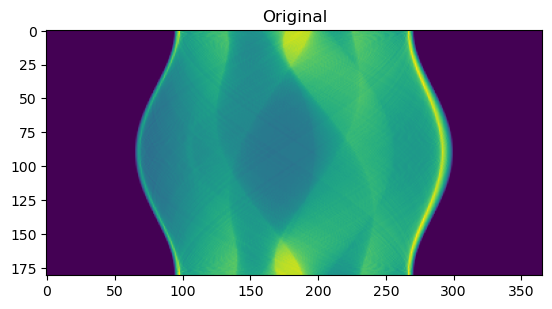

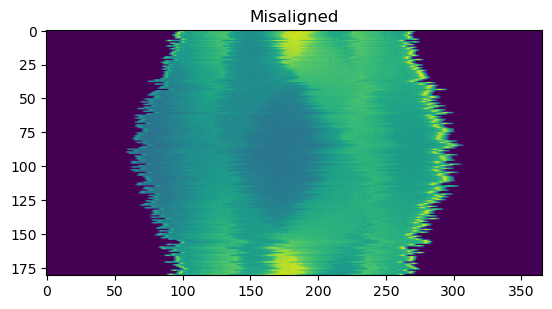

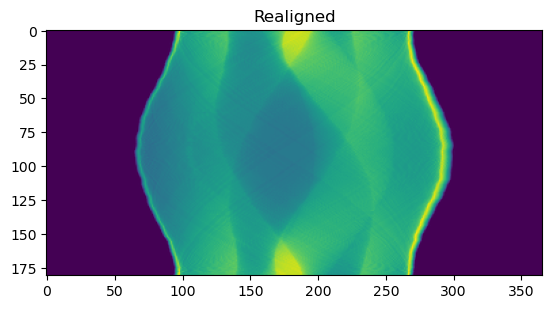

In [12]:
# Sinogram for original
plt.imshow(proj[:, 128, :])
plt.title('Original')
plt.show()

# Sinogram for misaligned
plt.imshow(proj_mis[:, 128, :])
plt.title('Misaligned')
plt.show()

# Sinogram for realgined
plt.imshow(proj_re[:, 128, :])
plt.title('Realigned')
plt.show()

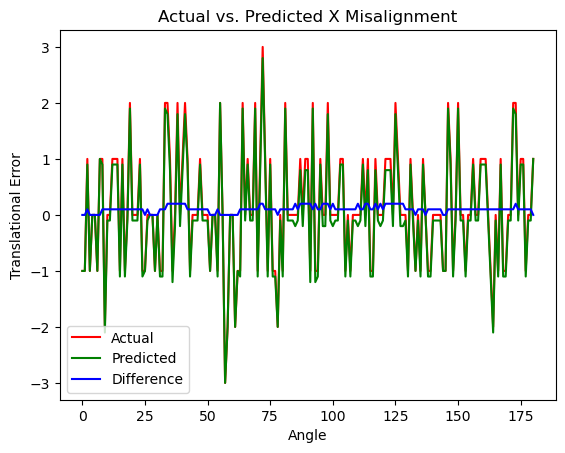

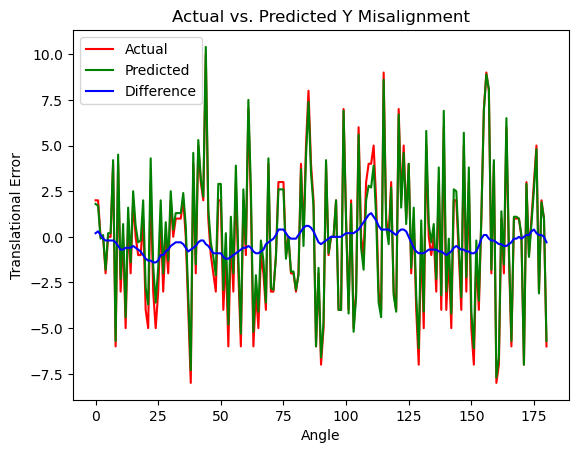

In [13]:
# Apply translations to original
true_x = mis_axis[:181, 1]
true_y = mis_axis[:181, 0]

# Plot shows the actual x misalignment vs. predicted
plt.plot(true_x, color = 'r', label = 'Actual')
plt.plot(sx, color = 'g', label = 'Predicted')
plt.plot(true_x - sx, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted X Misalignment")
plt.legend()
plt.show()

# Plot shows the actual x and y misalignment vs. modeled
plt.plot(true_y, color = 'r', label = 'Actual')
plt.plot(sy, color = 'g', label = 'Predicted')
plt.plot(true_y - sy, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted Y Misalignment")
plt.legend()
plt.show()

## Twenty Iteration Joint Realignment

In [14]:
# Use alignment algorithm with twenty iterations
proj_tmp, sx, sy, err = tomopy.align_joint(proj_mis.copy(), ang, iters = 20, algorithm = 'sirt')
proj_re = tomopy.shift_images(proj_tmp, sx, sy)

# Finding error for twenty iteration realignment
findError(proj_re, sx, sy, ang)

iter=0, err=0.2677649284946726
iter=1, err=0.015100166458424108
iter=2, err=0.0061522259297828626
iter=3, err=0.004655331443949784
iter=4, err=0.003173791576722069
iter=5, err=0.002923482155236859
iter=6, err=0.0025318098139456018
iter=7, err=0.0018323894142414146
iter=8, err=0.001562666943034828
iter=9, err=0.001562666943034828
iter=10, err=0.0013533092703223314
iter=11, err=0.0011049723921559792
iter=12, err=0.0011049723921559792
iter=13, err=0.0011049723921559792
iter=14, err=0.000956934162087539
iter=15, err=0.0013533092703223314
iter=16, err=0.0011049723921559792
iter=17, err=0.000781333471517414
iter=18, err=0.0012353966910606626
iter=19, err=0.0005524861960779896
(181, 256, 366)
(256, 366, 366)
(181, 256, 366)


6.944345489337134

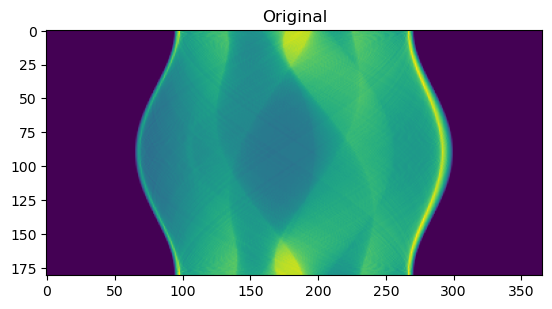

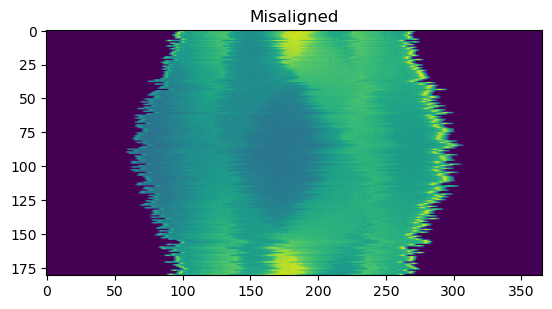

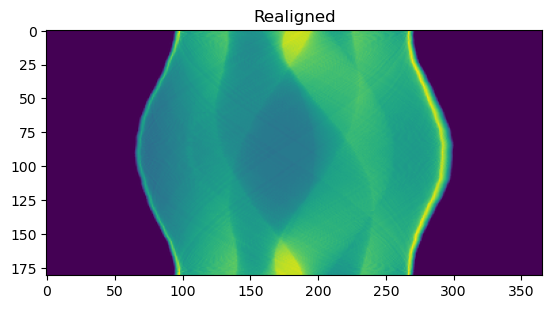

In [15]:
# Sinogram for original
plt.imshow(proj[:, 128, :])
plt.title('Original')
plt.show()

# Sinogram for misaligned
plt.imshow(proj_mis[:, 128, :])
plt.title('Misaligned')
plt.show()

# Sinogram for realgined
plt.imshow(proj_re[:, 128, :])
plt.title('Realigned')
plt.show()

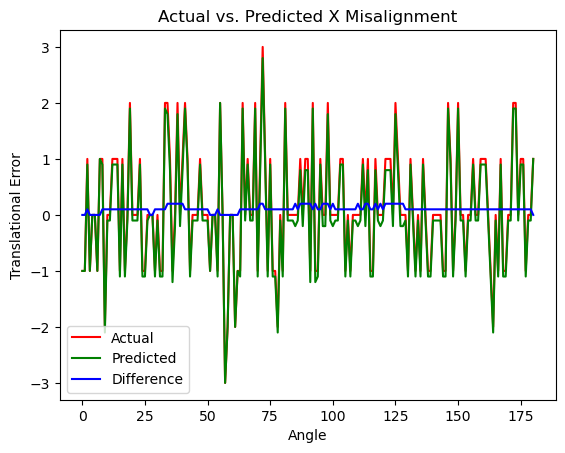

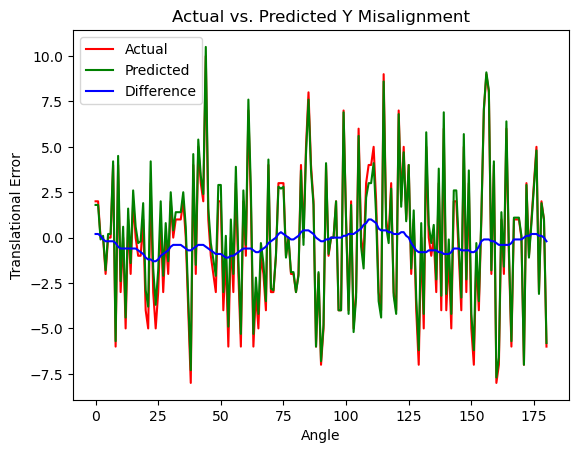

In [16]:
# Apply translations to original
true_x = mis_axis[:181, 1]
true_y = mis_axis[:181, 0]

# Plot shows the actual x misalignment vs. predicted
plt.plot(true_x, color = 'r', label = 'Actual')
plt.plot(sx, color = 'g', label = 'Predicted')
plt.plot(true_x - sx, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted X Misalignment")
plt.legend()
plt.show()

# Plot shows the actual x and y misalignment vs. modeled
plt.plot(true_y, color = 'r', label = 'Actual')
plt.plot(sy, color = 'g', label = 'Predicted')
plt.plot(true_y - sy, color = 'b', label = 'Difference')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted Y Misalignment")
plt.legend()
plt.show()